In [ ]:
import polars as pl
import marimo as mo

In [ ]:
df = pl.read_csv("data.csv")
df

year,pick,team,record,odds,pre_lottery_position,pick_change,player
i64,i64,str,str,f64,i64,i64,str
1985,1,"""New York Knicks""","""24-58""",0.1429,3,2,"""Patrick Ewing"""
1985,2,"""Indiana Pacers""","""22-60""",0.1429,1,-1,"""Wayman Tisdale"""
1985,3,"""Los Angeles Clippers""","""31-51""",0.1429,5,2,"""Benoit Benjamin"""
1985,4,"""Seattle SuperSonics""","""31-51""",0.1429,6,2,"""Xavier McDaniel"""
1985,5,"""Atlanta Hawks""","""34-48""",0.1429,7,2,"""Jon Koncak"""
…,…,…,…,…,…,…,…
2025,10,"""Houston Rockets""","""36-46""",0.038,9,-1,"""-"""
2025,11,"""Portland Trail Blazers""","""36-46""",0.037,10,-1,"""-"""
2025,12,"""Chicago Bulls""","""39-43""",0.017,12,0,"""-"""


In [ ]:
import random

def simulate_lottery(df) -> pl.DataFrame:
    return (
        df.group_by("year")
        .agg(
            pl.map_groups(
                exprs=["odds"],
                function=lambda series: random.choices(
                    series[0], weights=series[0], k=1
                )[0],
            )
        )
        .sort(by="year", descending=False)
        .select("year", pl.col("odds").list.first().log().alias("log_odds"))
        .get_column("log_odds")
        .sum()
    )


random.seed(42)
sims = [simulate_lottery(df) for _ in range(10_000)]

In [ ]:
actual = (
    df.filter(pl.col("pick") == 1)
    .select(["year", "team", "odds"])
    .with_columns(pl.col("odds").log().alias("log_odds"))
    .get_column("log_odds")
    .sum()
)
mo.md(f"The actual log odds of the draft are: **{actual:.4}**")

The actual log odds of the draft are: **-91.95**

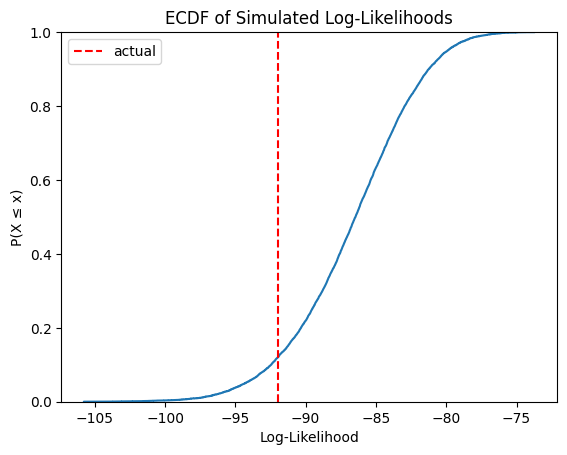

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.ecdfplot(data=pl.DataFrame({"log_odds": sims}), x="log_odds")
plt.axvline(actual, color="red", linestyle="--", label="actual")
plt.legend()
plt.title("ECDF of Simulated Log-Likelihoods")
plt.xlabel("Log-Likelihood")
plt.ylabel("P(X ≤ x)")
plt.show()